In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import glob
import os

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
files_joined = os.path.join('/content/drive/MyDrive/Inteligencia Artificial/Segundo Parcial/Proyecto', "Indicadores*csv")
list_files = glob.glob(files_joined)
df = pd.concat(map(pd.read_csv, list_files), ignore_index=True)
df.sample(n=5)

,AÑO,EXPEDIENTE,NOMBRE,RAMA,DESCRIPCIÓN RAMA,RAMA 6 DÍGITOS,SUBRAMA 2 DÍGITOS,LIQUIDEZ CORRIENTE,PRUEBA ÁCIDA,ENDEUDAMIENTO DEL ACTIVO,...,IMPACTO DE LA CARGA FINANCIERA,RENTABILIDAD NETA DEL ACTIVO,MARGEN BRUTO,MARGEN OPERACIONAL,RENTABILIDAD NETA DE VENTAS,RENTABILIDAD OPERACIONAL DEL PATRIMONIO,RENTABLIDAD FINANCIERA,UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS,ROE,ROA
54388,2018,60169,AVICOLA Y COMERCIALIZADORA ZARACAY AVI & COMZA...,A,"AGRICULTURA, GANADERÃA, SILVICULTURA Y PESCA.",A0146.01,A01,1.281382,0.107572,0.749802,...,0.000031,0.000937,0.062110,0.000554,0.000347,0.005975,0.003743,0.001495,0.003743,0.000937
161002,2020,138119,EXPORTJAIME S.A.,G,COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÃ...,G4630.11,G46,1.291501,1.219644,0.851043,...,0.002070,0.073866,0.398231,0.346926,0.015115,11.381611,0.495889,1.695371,0.495889,0.073866
5974,2017,42464,INMOBILIARIA AMUS SA,L,ACTIVIDADES INMOBILIARIAS.,L6810.01,L68,38.569599,38.569599,0.003783,...,0.000000,0.008657,1.000000,0.084686,0.058933,0.012487,0.008690,0.012440,0.008690,0.008657
30056,2017,163026,ESTUDIO SPINGARN & MARKS S.A.,M,"ACTIVIDADES PROFESIONALES, CIENTÃFICAS Y TÃ‰C...",M6910.01,M69,1.078682,1.078682,0.535231,...,0.000378,0.120145,1.000000,0.167418,0.146462,0.295493,0.258505,0.137336,0.258506,0.120145
90986,2018,710136,VALOVALCO C.L.,L,ACTIVIDADES INMOBILIARIAS.,L6810.01,L68,0.913171,0.913171,0.590150,...,0.001328,0.165021,1.000000,0.148672,0.112903,0.530200,0.402639,0.217302,0.402639,0.165021


In [ ]:
df = df[(df['ROE']>-1) & (df['ROE']<1) &(df['ROA']>-1) & (df['ROA']<1) & (df['ENDEUDAMIENTO DEL ACTIVO']<6) & (df['RENTABILIDAD NETA DE VENTAS']>-50) & 
        (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ']>-5) & (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ']<5) & (df['RENTABLIDAD FINANCIERA']<500)]
df['ROA_DIS'] = pd.qcut(df['ROA'], 3, labels=False)

In [ ]:
# Crear los arreglos con los inputs escogidos y el target del ROA
inputs_rlg = df[['RENTABILIDAD NETA DEL ACTIVO',  'UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ', 'RENTABLIDAD FINANCIERA', 'RENTABILIDAD NETA DE VENTAS']].values
targets_rlg = df['ROA_DIS'].values
print('Input #1: ', inputs_rlg[1], ' - Tamaño: ', inputs_rlg.shape,
      '\nTarget #1: ', targets_rlg[1], ' - Tamaño: ', targets_rlg.shape)

Input #1:  [0.02223394 0.21433391 0.05166009 0.03359371]  - Tamaño:  (188887, 4) 
Target #1:  1  - Tamaño:  (188887,)


In [ ]:
# Normalizar los inputs
bs=32
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
scaler = StandardScaler()
x_train = scaler.fit_transform(inputs_rlg)

In [ ]:
x_train = torch.from_numpy(x_train.astype(np.float32))
y_train = torch.from_numpy(targets_rlg.astype(np.int64))

In [ ]:
class MultilayerPerceptron(torch.nn.Module):
  def __init__(self, n_features, n_classes):
    super(MultilayerPerceptron, self).__init__()
    self.hidden_layer_1 = torch.nn.Linear(n_features, 64) # Primera capa oculta con 32 neuronas
    self.hidden_layer_2 = torch.nn.Linear(64, 32) # Segunda capa oculta con 16 neuronas
    self.hidden_layer_3 = torch.nn.Linear(32, 16) # Segunda capa oculta con 16 neuronas
    self.output_layer = torch.nn.Linear(16, n_classes) # Capa de salida con 3 neuronas
    self.relu = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=1)

  def forward(self, x):
    hidden_1 = self.relu(self.hidden_layer_1(x))
    hidden_2 = self.relu(self.hidden_layer_2(hidden_1))
    hidden_3 = self.relu(self.hidden_layer_3(hidden_2))
    y_hat = self.softmax(self.output_layer(hidden_3))
    return y_hat

"""class MultilayerPerceptron(torch.nn.Module):
  def __init__(self, n_features, n_classes):
    super(MultilayerPerceptron, self).__init__()
    self.hidden_layer = torch.nn.Linear(n_features, 10) # Capa oculta con 10 neuronas
    self.output_layer = torch.nn.Linear(10, n_classes) # Capa de salida con 3 neuronas
    self.relu = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=1)

  def forward(self, x):
    hidden = self.relu(self.hidden_layer(x))
    y_hat = self.softmax(self.output_layer(hidden))
    return y_hat"""

#función que visualiza la evolución de la perdida y la precisión en cada epoch
def plot_loss(epochs, loss, acc):
  plt.figure(figsize=(10, 5))
  xlim = len(loss)
  plt.plot(epochs,loss)
  plt.plot(epochs,acc)
  plt.xlabel('Epochs')
  plt.ylabel('Value')
  plt.legend(('Train loss','Accuracy'),loc='upper right',shadow=True)
  plt.title('Train Loss vs Accuracy')

#función que realiza el entrenamiento
def train(num_epochs, optimizer, cost, model):
  #listas usadas para guardar los valores de pérdida, precisión, para cada epoch
  #esta información sirve para graficar el proceso de entrenamiento
  loss_vals = []
  acc_vals = []
  epoch_vals = []
  
  #entrenamiento
  for epoch in range(num_epochs):
    y_hat = model(x_train)
    loss = cost(y_hat,y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #se evalua cada 5 epochs
    if (epoch+1)%999 == 0:
      with torch.no_grad():
        loss_vals.append(loss.item())
        y_hat_class = y_hat.argmax(dim=1)
        accuracy = (y_hat_class.eq(y_train).sum())/float(y_hat.shape[0])
        acc_vals.append(accuracy.item())
        epoch_vals.append(epoch+1)
      print(f'epoch:{epoch+1} loss={loss.item()} accuracy={accuracy.item()}')
        
  #se grafica el proceso de entrenamiento
  plot_loss(epoch_vals, loss_vals, acc_vals)

epoch:999 loss=0.5558637976646423 accuracy=0.995436429977417


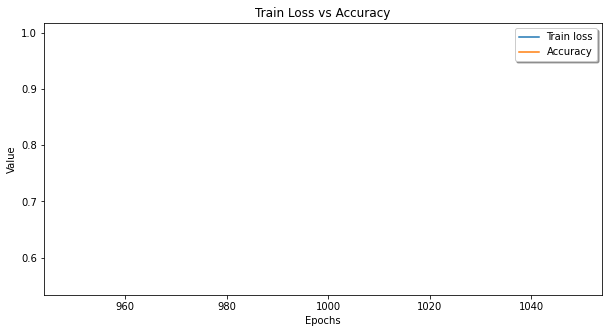

In [ ]:
model_rlg = MultilayerPerceptron(inputs_rlg.shape[1], len(np.unique(targets_rlg)))
optimizer = torch.optim.Adam(model_rlg.parameters(), lr=0.09)
cost = torch.nn.CrossEntropyLoss()
# se entrena el modelo
train(num_epochs=1000, optimizer=optimizer, cost=cost, model=model_rlg)

In [ ]:
desc = ['COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÃ“N DE VEHÃCULOS AUTOMOTORES Y MOTOCICLETAS.', 'INDUSTRIAS MANUFACTURERAS.', 'AGRICULTURA, GANADERÃA,  SILVICULTURA Y PESCA.', 'CONSTRUCCIÃ“N.',
       'ACTIVIDADES PROFESIONALES, CIENTÃFICAS Y TÃ‰CNICAS.', 'ACTIVIDADES DE ALOJAMIENTO Y DE SERVICIO DE COMIDAS.','INFORMACIÃ“N Y COMUNICACIÃ“N.','ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE APOYO.',
       'ACTIVIDADES DE ATENCIÃ“N DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL.','TRANSPORTE Y ALMACENAMIENTO.', 'ACTIVIDADES INMOBILIARIAS.', 'EXPLOTACIÃ“N DE MINAS Y CANTERAS.', 'OTRAS ACTIVIDADES DE SERVICIOS.',
       'DISTRIBUCIÃ“N DE AGUA ALCANTARILLADO, GESTIÃ“N DE DESECHOS Y ACTIVIDADES DE SANEAMIENTO.','SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE ACONDICIONADO.',
       'ARTES, ENTRETENIMIENTO Y RECREACIÃ“N.', 'ENSEÃ‘ANZA.', 'ACTIVIDADES FINANCIERAS Y DE SEGUROS.','ACTIVIDADES DE ORGANIZACIONES Y Ã“RGANOS EXTRATERRITORIALES.']

In [ ]:
desc_good = ["COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÓN DE VEHÍCULOS AUTOMOTORES Y MOTOCICLETAS.", "INDUSTRIAS MANUFACTURERAS.","AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA.", "CONSTRUCCIÓN.", 
 "ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y TÉCNICAS.","ACTIVIDADES DE ALOJAMIENTO Y DE SERVICIO DE COMIDAS.", "INFORMACIÓN Y COMUNICACIÓN.", "ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE APOYO.",
"ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y DE ASISTENCIA SOCIAL.", "TRANSPORTE Y ALMACENAMIENTO.", "ACTIVIDADES INMOBILIARIAS.", "EXPLOTACIÓN DE MINAS Y CANTERAS.",
"OTRAS ACTIVIDADES DE SERVICIOS.", "DISTRIBUCIÓN DE AGUA ALCANTARILLADO, GESTIÓN DE DESECHOS Y ACTIVIDADES DE SANEAMIENTO.","SUMINISTRO DE ELECTRICIDAD, GAS, VAPOR Y AIRE ACONDICIONADO.", 
 "ARTES, ENTRETENIMIENTO Y RECREACIÓN.", "ENSEÑANZA.", "ACTIVIDADES FINANCIERAS Y DE SEGUROS.","ACTIVIDADES DE ORGANIZACIONES Y ÓRGANOS EXTRATERRITORIALES."]

In [ ]:
print(model_rlg)

MultilayerPerceptron(
  (hidden_layer_1): Linear(in_features=4, out_features=64, bias=True)
  (hidden_layer_2): Linear(in_features=64, out_features=32, bias=True)
  (hidden_layer_3): Linear(in_features=32, out_features=16, bias=True)
  (output_layer): Linear(in_features=16, out_features=3, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)


In [ ]:
def categoria_rlg():
  # Remover Outliers
  dfp = df[(df['ROE']>-1) & (df['ROE']<1) &(df['ROA']>-1) & (df['ROA']<1) & (df['ENDEUDAMIENTO DEL ACTIVO']<6) & (df['RENTABILIDAD NETA DE VENTAS']>-50) & 
        (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ']>-5) & (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ']<5) & (df['RENTABLIDAD FINANCIERA']<500)]

  dfp['ROA_DIS'] = pd.qcut(dfp['ROA'], 3, labels=False)
  #dfp["DESCRIPCIÓN RAMA"] = dfp[["DESCRIPCIÓN RAMA"]].values
  metrics = {"Categoria": [], "MAE": [], "MSE": [], "RMSE": [], "ACC": []}
  dfp['DESCRIPCIÓN RAMA'].replace(desc, desc_good, inplace=True)
  grouped = dfp.groupby("DESCRIPCIÓN RAMA")
  for name, group in grouped:
      inputs_rlg = group[['RENTABILIDAD NETA DEL ACTIVO',  'UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ', 'RENTABLIDAD FINANCIERA', 'RENTABILIDAD NETA DE VENTAS']].values
      targets_rlg = group[['ROA_DIS']].values
      # Escalando los datos
      scaler = StandardScaler()
      inputs = scaler.fit_transform(inputs_rlg)
      # Transformando los datos a tensores
      inputs_rlg = torch.from_numpy(inputs.astype(np.float32))
      targets_rlg = torch.from_numpy(targets_rlg.astype(np.int64))
      # Creando el conjunto de datos de test
      dataset_test = TensorDataset(inputs_rlg, targets_rlg)
      test_loader = DataLoader(dataset_test, batch_size=bs, shuffle=True)
      # Evaluando el modelo
      y_pred = []
      y_true = []
      model_rlg.train(False)
      for inputs, targets in test_loader:
        y_hat_test = model_rlg(inputs).data.numpy()
        y_hat_class = np.argmax(y_hat_test, axis=1)
        y_pred.extend(y_hat_class)
        y_true.extend(targets.numpy())
      # Calculando metricas
      mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
      mse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=True)
      rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
      acc = accuracy_score(y_true, y_pred)
      # Imprimiendo los resultados
      metrics["Categoria"].append(name)
      metrics["MAE"].append(mae)
      metrics["MSE"].append(mse)
      metrics["RMSE"].append(rmse)
      metrics["ACC"].append(acc)
          
  metrics_df_ = pd.DataFrame(metrics)
  return metrics_df_

In [ ]:
metrics_rlg = categoria_rlg()

In [ ]:
metrics_rlg.sort_values("ACC", ascending=False)

,Categoria,MAE,MSE,RMSE,ACC
16,OTRAS ACTIVIDADES DE SERVICIOS.,0.072267,0.072267,0.268826,0.927733
12,ENSEÑANZA.,0.103690,0.104428,0.323153,0.896679
10,CONSTRUCCIÓN.,0.125271,0.125271,0.353937,0.874729
15,INFORMACIÓN Y COMUNICACIÓN.,0.142343,0.144329,0.379906,0.858650
7,"AGRICULTURA, GANADERÍA, SILVICULTURA Y PESCA.",0.145672,0.146477,0.382723,0.854730
11,"DISTRIBUCIÓN DE AGUA ALCANTARILLADO, GESTIÓN D...",0.161883,0.168772,0.410818,0.841561
9,COMERCIO AL POR MAYOR Y AL POR MENOR REPARACIÓ...,0.158655,0.158784,0.398477,0.841409
1,ACTIVIDADES DE ATENCIÓN DE LA SALUD HUMANA Y D...,0.161006,0.164528,0.405621,0.840755
18,TRANSPORTE Y ALMACENAMIENTO.,0.193956,0.194190,0.440670,0.806161
3,ACTIVIDADES DE SERVICIOS ADMINISTRATIVOS Y DE ...,0.215209,0.215364,0.464074,0.784868


In [ ]:
def procesar_rlg(año):
    # Remover Outliers
    dfl = df[(df['ROE'] > -1) & (df['ROE'] < 1) & (df['ROA'] > -1) & (df['ROA'] < 1) & (df['ENDEUDAMIENTO DEL ACTIVO'] < 6) & (df['RENTABILIDAD NETA DE VENTAS'] > -50) &
            (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS '] > -5) & (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS '] < 5) & (df['RENTABLIDAD FINANCIERA'] < 500)]
    dfl['ROA_DIS'] = pd.qcut(dfl['ROA'], 3, labels=False)
    dfl = dfl[dfl['AÑO'] == año]
    # Input y Targets
    inputs_rlg = dfl[['RENTABILIDAD NETA DEL ACTIVO',  'UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ', 'RENTABLIDAD FINANCIERA', 'RENTABILIDAD NETA DE VENTAS']].values
    targets_rlg = dfl[['ROA_DIS']].values
    # Escalando los datos
    scaler = StandardScaler()
    inputs = scaler.fit_transform(inputs_rlg)
    # Transformando los datos a tensores
    inputs_rlg = torch.from_numpy(inputs.astype(np.float32))
    targets_rlg = torch.from_numpy(targets_rlg.astype(np.int64))
    # Creando el conjunto de datos de test
    dataset_test = TensorDataset(inputs_rlg, targets_rlg)
    test_loader = DataLoader(dataset_test, batch_size=bs, shuffle=True)
    # Evaluando el modelo
    y_pred = []
    y_true = []
    model_rlg.train(False)
    for inputs, targets in test_loader:
        y_hat_test = model_rlg(inputs).data.numpy()
        y_hat_class = np.argmax(y_hat_test, axis=1)
        y_pred.extend(y_hat_class)
        y_true.extend(targets.numpy())
    # Calculando metricas
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=True)
    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    acc = accuracy_score(y_true, y_pred)

    # Imprimiendo los resultados
    print(f"\nResultados para el año {año} - con {len(targets_rlg)} datos:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print('Accuracy: {:.2f}%'.format(acc*100))

In [ ]:
#Arreglo años
years = [2017, 2018, 2019, 2020]

#Bucle para ejecutar proceso para cada año
for year in years:
    procesar_rlg(year)


Resultados para el año 2017 - con 46592 datos:
MAE: 0.10186298076923077
MSE: 0.10194883241758242
RMSE: 0.31929427244719316
Accuracy: 89.82%

Resultados para el año 2018 - con 48087 datos:
MAE: 0.08811113190675235
MSE: 0.08815272318921955
RMSE: 0.2969052427782634
Accuracy: 91.19%

Resultados para el año 2019 - con 48657 datos:
MAE: 0.04067246233840968
MSE: 0.041289023162134945
RMSE: 0.20319700579027966
Accuracy: 95.96%

Resultados para el año 2020 - con 45551 datos:
MAE: 0.22161972294790455
MSE: 0.22166362977761192
RMSE: 0.4708116712419223
Accuracy: 77.84%


In [ ]:
def procesar_rlg_all():
    # Remover Outliers
    dfl = df[(df['ROE'] > -1) & (df['ROE'] < 1) & (df['ROA'] > -1) & (df['ROA'] < 1) & (df['ENDEUDAMIENTO DEL ACTIVO'] < 6) & (df['RENTABILIDAD NETA DE VENTAS'] > -50) &
            (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS '] > -5) & (df['UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS '] < 5) & (df['RENTABLIDAD FINANCIERA'] < 500)]
    dfl['ROA_DIS'] = pd.qcut(dfl['ROA'], 3, labels=False)
    # Input y Targets
    inputs_rlg = dfl[['RENTABILIDAD NETA DEL ACTIVO',  'UTILIDAD OPERACIONAL/TOTAL DE ACTIVOS ', 'RENTABLIDAD FINANCIERA', 'RENTABILIDAD NETA DE VENTAS']].values
    targets_rlg = dfl[['ROA_DIS']].values
    # Escalando los datos
    scaler = StandardScaler()
    inputs = scaler.fit_transform(inputs_rlg)
    # Transformando los datos a tensores
    inputs_rlg = torch.from_numpy(inputs.astype(np.float32))
    targets_rlg = torch.from_numpy(targets_rlg.astype(np.int64))
    # Creando el conjunto de datos de test
    dataset_test = TensorDataset(inputs_rlg, targets_rlg)
    test_loader = DataLoader(dataset_test, batch_size=bs, shuffle=True)
    # Evaluando el modelo
    y_pred = []
    y_true = []
    model_rlg.train(False)
    for inputs, targets in test_loader:
        y_hat_test = model_rlg(inputs).data.numpy()
        y_hat_class = np.argmax(y_hat_test, axis=1)
        y_pred.extend(y_hat_class)
        y_true.extend(targets.numpy())
    # Calculando metricas
    mae = mean_absolute_error(y_true=y_true, y_pred=y_pred)
    mse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=True)
    rmse = mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    

    # Imprimiendo los resultados
    print(f"\nResultados para el año - con {len(targets_rlg)} datos:")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    print('Accuracy: {:.2f}%'.format(acc*100))
    print(f"Confunsion Matrix: ")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ROA Bueno','ROA Medio', 'ROA Malo'])
    disp.plot()
    plt.show()


Resultados para el año - con 188887 datos:
MAE: 0.0027953220708677676
MSE: 0.0028059104120452968
RMSE: 0.05297084492478194
Accuracy: 99.72%
Confunsion Matrix: 


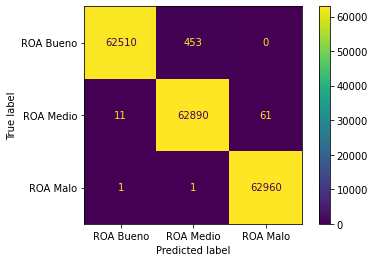

In [ ]:
procesar_rlg_all()